# Linear Discriminant Analysis (LDA)

Name: **Ashwin Sekhari** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Roll Number: **117CS0263**

Linear Discriminant Analysis (LDA) is a popular feature extraction technique for face image recognition and retrieval. In this assignment we will compare LDA and PCA. Both LDA and PCA are linear transformation techniques: LDA is a supervised whereas PCA is unsupervised – PCA ignores class labels.

## Includes

In [1]:
import math
import os
import numpy as np
import cv2
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def LDA(k):
    eig_val_f, eig_val_f = eigs(J, k)
    # projected training Fisher Faces 
    FF = np.matmul(eig_val_f.T, projected_faces).T

    # projected testing Fisher Faces
    FF_t = np.matmul(eig_val_f.T, projected_test_faces).T

    # calculating sample covarince for mahalanobis distance
    sample_cov = []
    for i in range(0, 360, 9):
        sample_cov.append(np.cov(FF[i:i + 9, :].T))
    sample_cov = np.array(sample_cov)

    result_tag1 = []
    result_tag2 = []
    for item in FF_t:
        mn_d1 = math.inf
        tg1 = ""
        mn_d2 = math.inf
        tg2 = ""
        for i in range(360):
            dd = item - FF[i]
            d1 = np.sum(np.square(dd))
            d2 = np.sum(dd * sample_cov[i // 9] * dd.T)

            if d1 < mn_d1:
                mn_d1 = d1
                tg1 = data_tag[i]

            if d2 < mn_d2:
                mn_d2 = d2
                tg2 = data_tag[i]
        result_tag1.append(tg1)
        result_tag2.append(tg2)

    cnt1 = 0
    for i in range(len(test_data_tag)):
        if result_tag1[i] == test_data_tag[i]:
            cnt1 += 1

    cnt2 = 0
    for i in range(len(test_data_tag)):
        if result_tag2[i] == test_data_tag[i]:
            cnt2 += 1
    
    return (cnt1 / len(test_data_tag) + k/11, cnt2 / len(test_data_tag) + k/9)

In [3]:
def PCA(k):
  # choosing k
  eig_val, eig_vec = eigs(surrogate_cov, k)

  eigen_faces = np.matmul(eig_vec.T, data.T)
  
  # generating signature for each face
  signature_face = np.matmul(eigen_faces, data).T
  
  # Testing starts here

  projected_faces = np.matmul(eigen_faces, test_data).T

  result_tag = []

  for test_f in projected_faces:
      temp_val = math.inf
      tag = ""
      for i in range(360):
          sm = np.sum(np.square(signature_face[i] - test_f))
          if sm < temp_val:
              temp_val = sm
              tag = data_tag[i]
      result_tag.append(tag)


  cnt = 0
  for i in range(len(test_data_tag)):
      if result_tag[i] == test_data_tag[i]:
        cnt += 1

  return cnt / len(result_tag)

## Read Data

In [4]:
path = os.path.join("att_faces")
data = []
data_t = []
data_tag = []

for i in os.scandir(os.path.join(path, "Training")):
    if i.is_dir():
        for j in os.scandir(i.path):
            if j.is_file():
                temp = np.ravel(cv2.imread(j.path, 0))
                data_t.append(temp)
                sm = np.sum(temp) / temp.size
                for k in range(temp.size):
                    temp[k] -= sm
                data.append(temp)
                data_tag.append(i.name)
 

In [5]:
data = np.array(data).T
 
data_cov = np.cov(data)

data_t = np.array(data_t).T
 
data_cov_t = np.cov(data_t)

# k = 360
eig_val, eig_vec = eigs(data_cov_t, k=360)
# projected_faces
projected_faces = np.matmul(eig_vec.T, data_t)

# here number of classes c = 40, so number of image per class = 360 / 40 = 9
class_mean = []
for i in range(0, 360, 9):
    k_ = []
    for j in range(360):
        sm = 0
        for k in range(9):
            sm += projected_faces[j][i + k]
        sm /= 9
        k_.append(sm)
    class_mean.append(k_)
 
class_mean = np.array(class_mean)
 
overall_mean = []
 
for i in range(360):
    overall_mean.append(np.sum(projected_faces[i]) / 360)
 
overall_mean = np.array(overall_mean)

In [6]:
# within class scatter matrix
SW = np.copy(projected_faces).T

for i in range(0, 360, 9):
    SW[i] -= class_mean[i // 9]

SW = np.cov(SW.T)
print(SW.shape)

# between class scatter matrix
SB = np.copy(class_mean)

for i in range(40):
    SB[i] -= overall_mean

SB = np.matmul(SB.T, class_mean)


# criterion function J
J = np.matmul(np.linalg.inv(SW), SB)

(360, 360)


## Testing

In [7]:
# testing
test_data = []
test_data_t = []
test_data_tag = []

for i in os.scandir(os.path.join(path, "Testing")):
    if i.is_dir():
        for j in os.scandir(i.path):
            if j.is_file():
                temp = np.ravel(cv2.imread(j.path, 0))
                test_data_t.append(temp)
                sm = np.sum(temp) / temp.size
                for k in range(temp.size):
                    temp[k] -= sm
                test_data.append(temp)
                test_data_tag.append(i.name)

test_data = np.array(test_data).T
test_data_t = np.array(test_data_t).T

projected_test_faces = np.matmul(eig_vec.T, test_data_t)

# calculating surrogate covariance
surrogate_cov = np.cov(data.T)

## Results

The results showed that LDA is much better than PCA in overall image with various disturbances. While in time taken evaluation, PCA is faster than LDA.

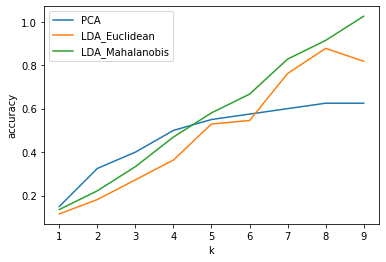

In [8]:
K = []
acc1 = []
acc2 = []
acc3 = []
for k in range(1, 10):
  K.append(k)

  accuracy = PCA(k)
  acc1.append(accuracy)

  accuracy = LDA(k)
  acc2.append(accuracy[0])

  acc3.append(accuracy[1])

plt.plot(K, acc1, label='PCA')
plt.plot(K, acc2, label='LDA_Euclidean')
plt.plot(K, acc3, label='LDA_Mahalanobis')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()